In [7]:
import os
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from tqdm import tqdm
from statsmodels.stats.diagnostic import unitroot_adf
import seaborn as sns

## Time series (N*T)

In [35]:
data = np.load("./project/nmos_inference/data_v4/original_3510_512.npy", mmap_mode='r')
data = data.astype(np.int64)

In [3]:
data.shape

(3510, 512)

## Correlation Analysis

<AxesSubplot:>

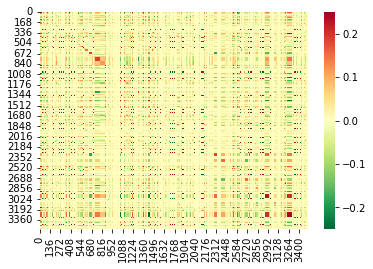

In [36]:
# sns.plot(data[0,:])
corr = np.cov(data)
sns.heatmap(corr, cmap="RdYlGn_r")

## Stability Analysis

The stability of state of transistor 0 is 
 (-4.144308923963539, 0.0008174802300597934, 18, 493, {'1%': -3.4436840273842058, '5%': -2.8674204319994674, '10%': -2.5699020441557052}, -1521.179744706159)


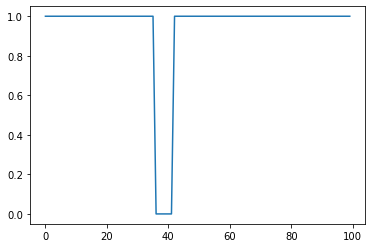

In [39]:
target = 0
length = 100
adf = unitroot_adf(data[target])
sns.lineplot(x=np.arange(length), y=data[target][:length])
print(f"The stability of state of transistor {target} is \n", adf)

The stability of transistor 0 is 
 (-8.888194417315596, 1.263330019857415e-14, 17, 493, {'1%': -3.4436840273842058, '5%': -2.8674204319994674, '10%': -2.5699020441557052}, -1501.4929434448436)


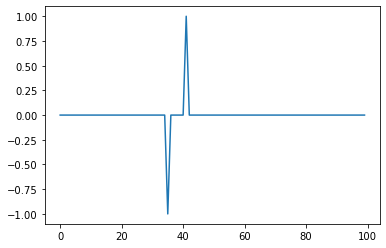

In [40]:
stablized_seq = np.diff(data[target], n=1)
adf = unitroot_adf(stablized_seq)
sns.lineplot(x=np.arange(length), y=stablized_seq[:length])
print(f"The stability of differed state of transistor {target} is \n", adf)

In [4]:
data_dict = {i: data[i] for i in range(data.shape[0])}
# screen the constant seq and approximately constant seq(fluctuations < 10)
## find peaks >= 10
peaks = []
num_spike = 5
for idx, seq in data_dict.items():
    # peaks.append(len(find_peaks(seq)[0])) # spike count
    if len(find_peaks(seq)[0]) >= num_spike:
        peaks.append(idx)

# screened seqs
data_dict = {i: data_dict[i] for i in peaks}


In [5]:
# synchronously change label
label = np.load("./project/nmos_inference/data_v4/causality_1st_label.npy", mmap_mode='r')
label = {(i, j): label[i, j] for j in data_dict for i in data_dict}
len(label)

2686321

In [6]:
df = pd.DataFrame()
df["id"] = range(len(label))
df["transistor_1"] = [key[0] for key, value in label.items()]
df["transistor_2"] = [key[1] for key, value in label.items()]
df["label"] = [value for key, value in label.items()]
df.to_csv("./project/nmos_inference/data_v4/full_1st.csv")

In [8]:
df

,id,transistor_1,transistor_2,label
0,0,1,1,0.0
1,1,2,1,0.0
2,2,5,1,0.0
3,3,6,1,0.0
4,4,8,1,0.0
...,...,...,...,...
2686316,2686316,3501,3506,0.0
2686317,2686317,3502,3506,0.0
2686318,2686318,3503,3506,0.0
2686319,2686319,3504,3506,0.0


### Make a 3 class version

In [32]:
for idx in tqdm(range(df.shape[0])):
    if df["label"].iloc[idx] == 1:
        t1, t2 = df["transistor_1"].iloc[idx], df["transistor_2"].iloc[idx]
        if df[(df["transistor_1"]==t2)&(df["transistor_2"]==t1)]["label"].values == 0:
            df[(df["transistor_1"]==t2)&(df["transistor_2"]==t1)]["label"] = 2

  0%|                                                                                                 | 254/1697809 [00:00<1:21:02, 349.08it/s]/tmp/ipykernel_561819/615416956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[(df["transistor_1"]==t2)&(df["transistor_2"]==t1)]["label"] = 2
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1697809/1697809 [1:00:36<00:00, 466.86it/s]


In [39]:
df.to_csv("./project/nmos_inference/data_v3/train_3class.csv")

### Check the data distribution

In [9]:
# Check if samples are balanced
print(df["label"].value_counts())

0.0    2675283
1.0      11038
Name: label, dtype: int64
